# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for CLT to hold (read CLT carefully), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the CLT, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> Start by computing the margin of error and confidence interval.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What test did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [246]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# read the csv file in as a dataframe
df = pd.read_csv('human_body_temperature.csv')

# display contents using .head()
df.head()

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


# 1. Is the distribution of body temperatures normal?

In [247]:
# print shape of dataframe
print('Shape of dataframe: ', df.shape)

Shape of dataframe:  (130, 3)


We only have 130 records in our dataframe. Although our analysis would be better with a larger data set, 130 records is an acceptable number of observations under the Central Limit Theorem (CLT). The CLT states that for 30 observations or more, a $t$ distribution is close enough to a $z$ distribution to effectively be the same. We can then assume under the CLT that with over 30 observations, we have a sufficient amount of data that the observations should follow a normal distribution.

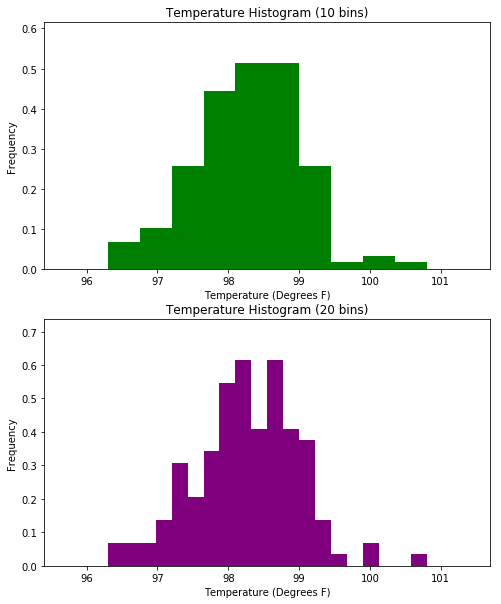

In [248]:
# set size of figures
fig = plt.figure(figsize=(8, 10))

# plot a histogram with 10 bins
plt.subplot(2,1,1)
_ = plt.hist(df['temperature'], bins=10, normed=True, color='green')
_ = plt.xlabel('Temperature (Degrees F)')
_ = plt.ylabel('Frequency')
_ = plt.title('Temperature Histogram (10 bins)')
_ = plt.margins(.2)

# plot a histogram with 20 bins
plt.subplot(2,1,2)
_ = plt.hist(df['temperature'], bins=20, normed=True, color='purple')
_ = plt.xlabel('Temperature (Degrees F)')
_ = plt.ylabel('Frequency')
_ = plt.title('Temperature Histogram (20 bins)')
_ = plt.margins(.2)

# display the histograms
plt.show()

Our histograms aren't perfectly normally distributed, but taking into consideration that we only have 130 observations, our histograms seem to follow a normal distribution somewhat closely. Let's double check the ECDFs of our data and with a sampled normal distribution.

In [249]:
# Sample a normal distribution for comparison
sample_normal = np.random.normal(np.mean(df['temperature']), np.std(df['temperature']), size=10000)

In [250]:
# define ECDF function
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # define n, the size of the dataset
    n = len(data)
    # set x values
    x = np.sort(data)
    # compute y values
    y = np.arange(1, n+1) / n
    return x, y

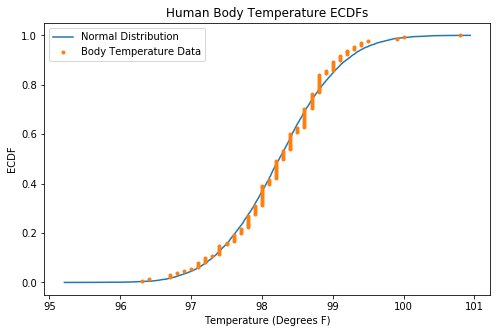

In [251]:
# compute the ecdfs of the data and the normal distribution
x_temp, y_temp = ecdf(df['temperature'])
x_normal, y_normal = ecdf(sample_normal)

# plot ECDFs
fig = plt.figure(figsize=(8, 5))
plt.subplot(1,1,1)
_ = plt.plot(x_normal, y_normal)
_ = plt.plot(x_temp, y_temp, marker='.', linestyle='none')
_ = plt.ylabel('ECDF')
_ = plt.xlabel('Temperature (Degrees F)')
_ = plt.title('Human Body Temperature ECDFs')
_ = plt.legend(('Normal Distribution', 'Body Temperature Data'))

# display the plot
plt.show()

After plotting the ECDF of our normal distribution sample with the ECDF of our results, we can see that the body temperature data pretty closely follows the normal distribution. We can assert that **the body temperature data is normally distributed**

# 2. Is the sample size large? Are the observations independent?

Our sample size is 130 observations, which is greater than the 30 observations needed for the data to follow the CLT. So yes, the sample size is technically large. The observations are also independent because they are taken from different people.

# 3. Is the true population mean really 98.6 degrees F?

* Would you use a one-sample or two-sample test? Why?
* In this situation, is it appropriate to use the  t  or  z  statistic?
* Now try using the other test. How is the result be different? Why?

We will use a one-sample test because there is only one set of data available and we are comparing it to a single mean. Since the sample size is greater than 30 observations, it's appropriate to use the $z$ statistic (The $t$ statistic is used if there are fewer than 30 observations).

In [252]:
# calculate and print sample statistics
df['temperature'].describe()

count    130.000000
mean      98.249231
std        0.733183
min       96.300000
25%       97.800000
50%       98.300000
75%       98.700000
max      100.800000
Name: temperature, dtype: float64

We will apply bootstrapping to test whether the the mean of the bootstrap sample and the mean of the data (98.6) are equal to each other.

In [253]:
# calculate p value using 10,000 bootstrap replicates
size=10000

# initiate empty bootstrap replicates array
bs_reps = np.empty(size)

# fill the boostrap replicates array
for i in range(size):
    bs_sample = np.random.choice(df['temperature'],len(df['temperature']))
    bs_reps[i] = np.mean(bs_sample)

# calculate p value
p = np.sum(bs_reps >= 98.6) / len(bs_reps)
print('p = ', p)

p =  0.0


The p value is 0.0 after creating 10,000 bootstrap replicates. Let's see if it makes a difference if we take 100,000 bootstrap samples instead of 10,000.

In [254]:
# calculate p value using 100,000 bootstrap replicates
size=100000

# initiate empty bootstrap replicates array
bs_reps = np.empty(size)

# fill the boostrap replicates array
for i in range(size):
    bs_sample = np.random.choice(df['temperature'],len(df['temperature']))
    bs_reps[i] = np.mean(bs_sample)

# calculate p value
p = np.sum(bs_reps >= 98.6) / len(bs_reps)
print('p = ', p)

p =  0.0


We still get a p value of 0.0. The p value is still so low even after taking ten times as many samples, which signals that the true mean isn't 98.6.

Since we have more than 30 samples, it's appropriate to use the $z$ statistic. We will find the $z$ score using the following equation:

$z$ = (sample mean - population mean) / (population stdev / sqrt(n))

where n is the size of the sample.

In [255]:
# calculate the z score
z = (np.mean(df['temperature']) - 98.6) / (np.std(df['temperature']) / np.sqrt(len(df['temperature'])))
print('z = ', round(z,3))

z =  -5.476


In [256]:
# perform two sided z test
p_z = stats.norm.sf(abs(z)) * 2
print('p = p( z <= ', round(z,3), ') + p( z >= ', abs(round(z,3)), ') = ', round(p_z,3))
print('p (unrounded) is ', p_z)

p = p( z <=  -5.476 ) + p( z >=  5.476 ) =  0.0
p (unrounded) is  4.35231516588e-08


We essentially get a p value of zero, signaling that it's highly unlikely that the true mean is 98.6.

Next, we'll find the $t$ statistic and compare it to the $z$ test. The $t$ score is calculated using the same equation as the $z$ score. Since our sample standard deviation is our population standard deviation, we can simply set $t$ equal to $z$ to start.

In [257]:
# set t equal to z for the t score
t = z
print('t = ', round(t,3))

t =  -5.476


In [258]:
# perform two sided t test
p_t = stats.t.sf(abs(t), len(df['temperature'])-1) * 2
print('p = p( t <= ', round(t,3), ') + p( t >= ', abs(round(t,3)), ') = ', round(p_t,3))
print('p (unrounded) is ', p_t)

p = p( t <=  -5.476 ) + p( t >=  5.476 ) =  0.0
p (unrounded) is  2.18874646241e-07


The $t$ and $z$ tests yield different p values, but both essentially yield p values of zero, confirming that **the true mean is not likely to be 98.6. **

# 4. Draw a small sample of size 10 from the data and repeat both tests.

* Which one is the correct one to use?
* What do you notice? What does this tell you about the difference in application of the  t  and  z  statistic?

Now that our sample size will be 10 observations, we will have to use the $t$ test to get an accurate p value.

In [259]:
# draw a random sample of 10 temperatures
sample = np.random.choice(df['temperature'], size=10)
print('Sample: ', sample)

Sample:  [ 96.3  97.1  98.6  97.   99.   98.3  98.   97.4  97.2  97.7]


In [260]:
# calculate the t score
t2 = (np.mean(sample) - 98.6) / (np.std(sample) / np.sqrt(len(sample)))
print('t = ', t2)

# perform two sided t test
p_t2 = stats.t.sf(abs(t2),len(sample)-1) * 2
print('p = p( t <= ', round(t2,3), ') + p( t >= ', abs(round(t2,3)), ') = ', round(p_t2,3))

t =  -3.81095000072
p = p( t <=  -3.811 ) + p( t >=  3.811 ) =  0.004


To compare, let's also perform a $z$ test. 

In [261]:
# calculate the z score
z2 = (np.mean(sample) - 98.6) / (np.std(df['temperature']) / np.sqrt(len(sample)))
print('z = ', z2)

# perform two sided z test
p_z2 = stats.norm.sf(abs(z2)) * 2
print('p = p( z <= ', round(z2,3), ') + p( z >= ', abs(round(z2,3)), ') = ', round(p_z2,3))
print('p (unrounded) is ', p_z2)

z =  -4.06997924362
p = p( z <=  -4.07 ) + p( z >=  4.07 ) =  0.0
p (unrounded) is  4.7017326519e-05


Our p values for the $z$ statistic and $t$ statistic are significantly different. This tells us that it's important to use the correct test statistic based on the sample size. Both can be appropriate for larger samples, but for sample sizes smaller than 30, it's better to use the $t$ test.

# 5. At what temperature should we consider someone's temperature to be "abnormal"?

* Start by computing the margin of error and confidence interval.

For this question, we're going to use a 95% confidence interval to test whether someone's temperature is "abnormal".

In [262]:
# display mean temperature
print('The mean temperature for our data is ', round(np.mean(df['temperature']),3), 'degrees F')

# set z_critical variable for 95% confidence interval
z_critical = 1.96

# calculate margin of error
margin_error = z_critical * np.std(df['temperature']) / np.sqrt(len(df['temperature']))

# print resulting margin of error
print('The margin of error is ', round(margin_error,3), ' degrees F')

The mean temperature for our data is  98.249 degrees F
The margin of error is  0.126  degrees F


In [263]:
# calculate 95% confidence interval
conf_int = np.percentile(df['temperature'], [2.5, 97.5])
print('95% confidence interval: ', conf_int)

95% confidence interval:  [ 96.7225  99.4775]


Any temperature **less than 96.7225 degrees F or greater than 99.4775 degrees F should be considered abnormal.**

# 6. Is there a significant difference between males and females in normal temperature?

* What test did you use and why?
* Write a story with your conclusion in the context of the original problem.

In [264]:
# extract male and female temperatures
male_temp = df[df['gender'] == 'M']['temperature']
female_temp = df[df['gender'] == 'F']['temperature']

# display sample statistics for both male and female
print('Male Sample Statistics:')
print(male_temp.describe(), '\n')
print('Female Sample Statistics:')
print(female_temp.describe(), '\n')

# calculate and display difference in means for male and female temperatures
print('Difference between mean male temperature and mean female temperature:', 
      round(abs(np.mean(male_temp) - np.mean(female_temp)), 3), 'degrees F')

Male Sample Statistics:
count    65.000000
mean     98.104615
std       0.698756
min      96.300000
25%      97.600000
50%      98.100000
75%      98.600000
max      99.500000
Name: temperature, dtype: float64 

Female Sample Statistics:
count     65.000000
mean      98.393846
std        0.743488
min       96.400000
25%       98.000000
50%       98.400000
75%       98.800000
max      100.800000
Name: temperature, dtype: float64 

Difference between mean male temperature and mean female temperature: 0.289 degrees F


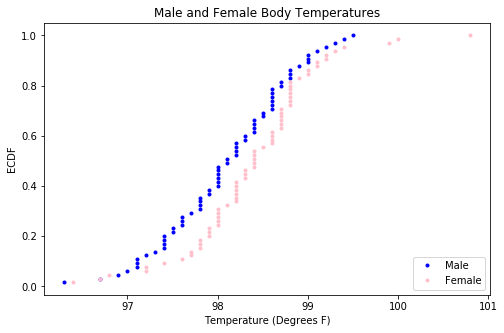

In [265]:
# compute ECDFs
x_male, y_male = ecdf(male_temp)
x_female, y_female = ecdf(female_temp)

# plot ECDFs
fig = plt.figure(figsize=(8, 5))
_ = plt.plot(x_male, y_male, marker='.', linestyle='none', color='blue')
_ = plt.plot(x_female, y_female, marker='.', linestyle='none', color='pink')
_ = plt.ylabel('ECDF')
_ = plt.xlabel('Temperature (Degrees F)')
_ = plt.title('Male and Female Body Temperatures')
_ = plt.legend(('Male', 'Female'), loc=4)
plt.show()

There is a clear difference in the male and female temperature distributions. Male temperatures tend skew lower than female temperatures with a difference of 0.289 degrees F between their sample means.

To see if there's a significant difference between male and female body temperatures, we will use a **two sample permutation test**. Permutation tests are useful when testing whether two sets of data have identical probability distributions.

*Null hypothesis: there is no difference in the means and distributions of male and female body temperatures.*

In [266]:
# define diff_of_means function
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""
    # The difference of means of data_1, data_2: diff
    diff = abs(np.mean(data_1) - np.mean(data_2))
    # return the difference
    return diff

In [267]:
# compute difference in means of male and female body temperatures
diff_observed = diff_of_means(male_temp, female_temp)

# initiate empty permutation replicates array
size = 100000
perm_reps = np.empty(size)

# fill the permutation replicates array
for i in range(size):
    concat_perm_temp = np.random.permutation(np.concatenate((male_temp, female_temp)))
    male_perm = concat_perm_temp[:len(male_temp)]
    female_perm = concat_perm_temp[len(male_temp):]
    perm_reps[i] = diff_of_means(male_perm, female_perm)
    
# compute the p value
p = np.sum(perm_reps >= diff_observed) / len(perm_reps)

# print out results
print('Observed difference: ', round(diff_observed, 3), 'degrees F' )
print('p value: ', round(p, 3))

Observed difference:  0.289 degrees F
p value:  0.025


Since our p value is less than 0.05 (the cutoff value for significance), **we reject the null hypothesis** that there is no difference in the means and distributions of male and female body temperatures. **There is indeed a significant difference between the means and distributions of our male and female body temperatures.**

# Conclusions

In his 1868 book, Carl Wunderlich first conceptualized and reported that the mean normal body temperature was 37 degrees C or 98.6 degrees F. After performing some statistical tests of our own, we've come to the conclusion that this value is not accurate. Based on a sample of 130 observations, we estimated the mean human body temperature to be 98.2 degrees F and we're 95% confident that the mean lies in the interval of [96.7, 99.5] degrees F (95% confidence interval). In addition to this, we discovered that male and female body temperatures are significantly different and that women tend to have higher body temperatures than men.